In [1]:
import pink_utils as pu
import pandas as pd
import numpy as np
import time

In [2]:
hm = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images_EDMatrix.bin')
images = pu.image_binary('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images.bin')

In [3]:
df = pd.read_csv('../Experiment/Experiment_F3W2_95_5/Test_Images/RGZ_Test_Images_Dataframe.csv')

In [4]:
df.shape

(7464, 78)

In [5]:
images.file_head

(7464, 2, 167, 167)

In [6]:
hm.file_head

(7464, 15, 15, 1)

In [9]:
before = time.time()
print(f'Before time is {before}')
print('Loading the heatmaps')
maps = [hm.ed(index=i, prob=True) for i in range(hm.file_head[0])]

# print('Loading the FIRST pre-processed images')
# first = [images.get_image(index=i, channel=0) for i in range(hm.file_head[0])]

# print('Loading the WISE pre-processed images')
# wise = [images.get_image(index=i, channel=1) for i in range(hm.file_head[0])]

print('Loading the cube pre-processed images')
cubes = [np.concatenate([images.get_image(index=i, channel=0).flatten(), images.get_image(index=i, channel=1).flatten()]) for i in range(hm.file_head[0])]

after = time.time()
print(f'After time is {after}')
print(f'\tTime difference is {after-before}')


Before time is 1530069868.6723368
Loading the heatmaps
Loading the cube pre-processed images
After time is 1530069913.148629
	Time difference is 44.4762921333313


In [10]:
import matplotlib.pyplot as plt

In [11]:
from collections import defaultdict

In [12]:
book = defaultdict(list)

for c, row in df.iterrows():
    book[row['label']].append(maps[c])

In [13]:
som = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_6_19.bin')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


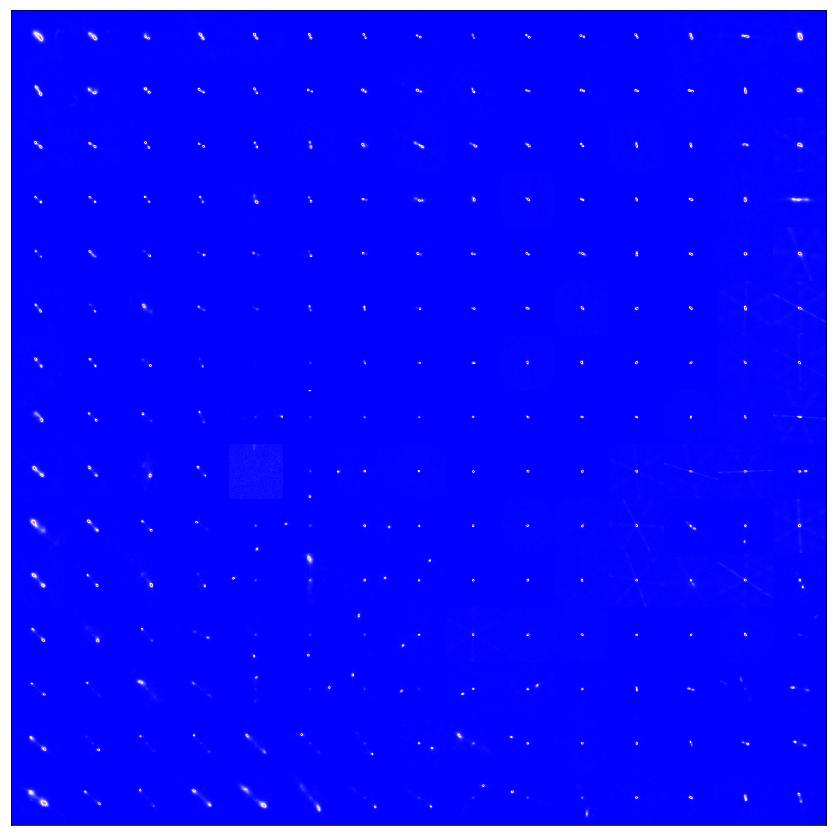

In [15]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=0), cmap='bwr')
pu.no_ticks(ax)

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


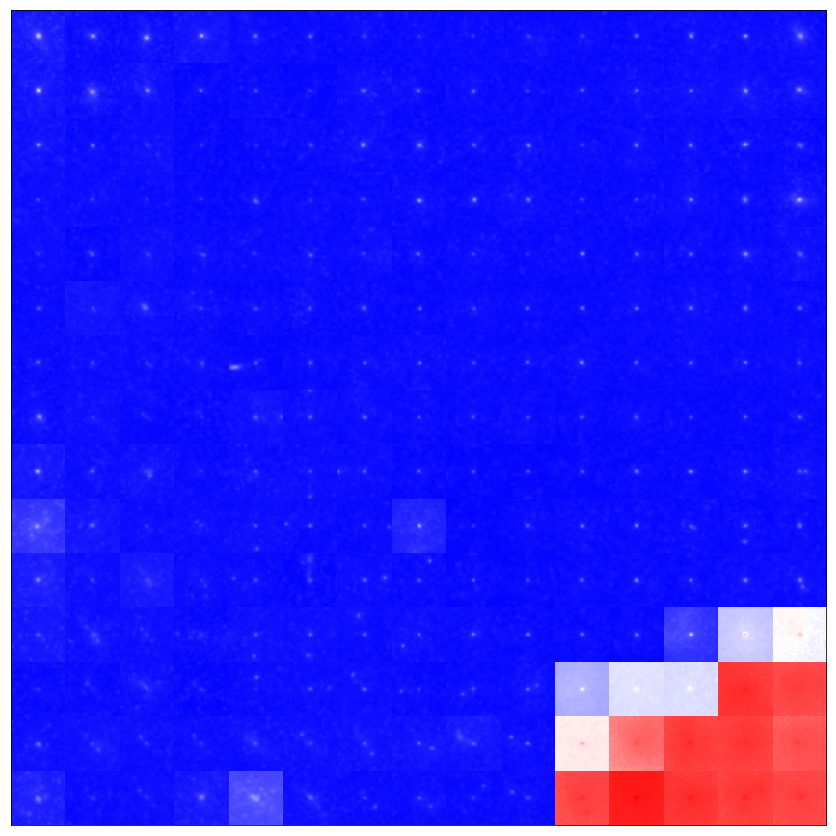

In [16]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=1), cmap='bwr')
pu.no_ticks(ax)

fig.show()

In [17]:
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn import cross_validation

/Users/gal16b/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
np.array(cubes).shape

(7464, 55778)

In [21]:
np.random.seed(7464)
index = np.random.permutation(len(maps))

labels = df['label']
num_comp  = np.array([int(i.split('_')[0]) for i in labels])[index]
num_peaks = np.array([int(i.split('_')[1]) for i in labels])[index]

# Keep heat maps to ensure nothing else breaks
heatmaps  = np.array(cubes)[index]

total = heatmaps.shape[0]

suf_df = df.iloc[index]


In [25]:
before = time.time()
print(f'Before time is {before}')

n_estimators = 10 # how many trees, should be 256
cores = 2 # number of cpu cores to speed it up

peaks_rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)
comp_rf  = RandomForestRegressor(n_estimators=n_estimators, n_jobs=cores, bootstrap=True)

print('Peaks training')
peaks_res = cross_validation.cross_val_predict(peaks_rf, heatmaps, num_peaks, cv=5, n_jobs=-1)

print('Comp training')
comp_res = cross_validation.cross_val_predict(comp_rf, heatmaps, num_comp, cv=5, n_jobs=-1)

after = time.time()
print(f'After time is {after}')
print(f'\tTime difference is {after-before}')


Before time is 1530075477.5211442
Peaks training
Comp training
After time is 1530082664.917517
	Time difference is 7187.396372795105


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


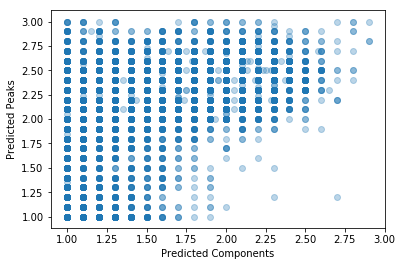

In [26]:
fig, ax = plt.subplots(1,1)

ax.scatter(comp_res, peaks_res, alpha=0.3)

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()

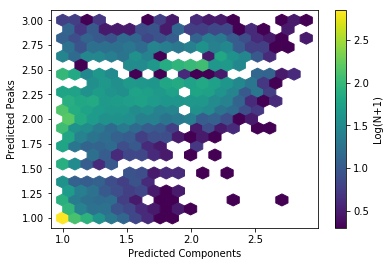

In [27]:
fig, ax = plt.subplots(1,1)

hb = ax.hexbin(comp_res, peaks_res, 
               bins='log', gridsize=20, mincnt=1)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Log(N+1)')

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

# fig.show()
fig.savefig('Images/Predicted_Features_Heatmap.pdf')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


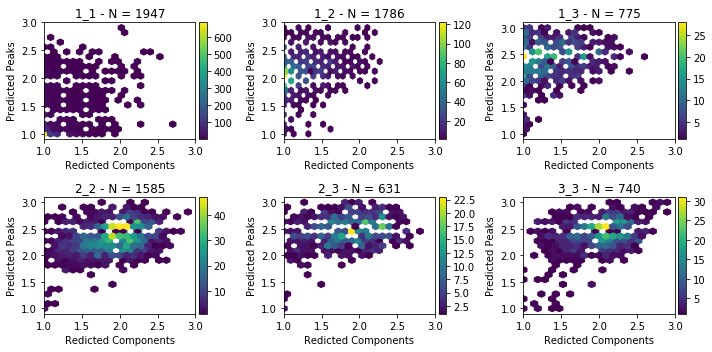

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def subplot_cbar(fig, ax, im):
        divider = make_axes_locatable(ax)
        cax0 = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax0)
    

fig, axes = plt.subplots(2,3, figsize=(10, 5))

for c, l in enumerate(np.sort(labels[index].unique())):
    mask = l == labels[index]
    
    ax = axes.flatten()[c]
    im = ax.hexbin(comp_res[mask], peaks_res[mask], gridsize=20, mincnt=1)
    ax.set(title=f'{l} - N = {np.sum(mask)}', xlim=[1,3],
          xlabel='Redicted Components',
          ylabel='Predicted Peaks')
    
    subplot_cbar(fig, ax, im)
    
fig.tight_layout()
fig.show()
fig.savefig('Images/Predicted_Features_Heatmap_Classes.pdf')

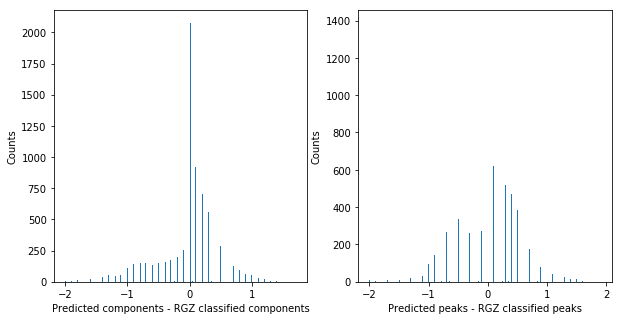

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist( comp_res - num_comp, bins=250 )
ax1.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

ax2.hist( peaks_res - num_peaks, bins=250 )
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')


# fig.show()
fig.savefig('Images/Predicted_Featurs_Histogram.pdf')

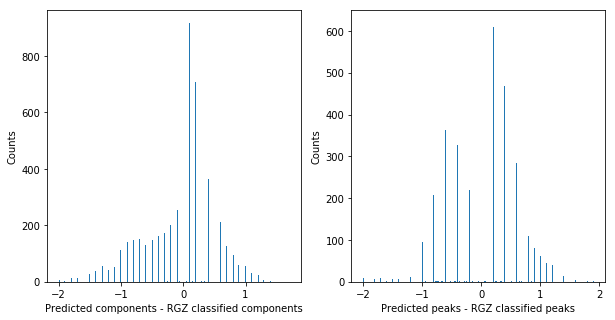

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

val = comp_res - num_comp
ax1.hist( val[val!=0], bins=250 )
ax1.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

val = peaks_res - num_peaks
ax2.hist(val[val != 0], bins=250 )
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')


# fig.show()
fig.savefig('Images/Predicted_Featurs_Histogram_No_Zero.pdf')

0.6-0.7
0.7-0.8
0.8-0.9
0.9-1.0


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


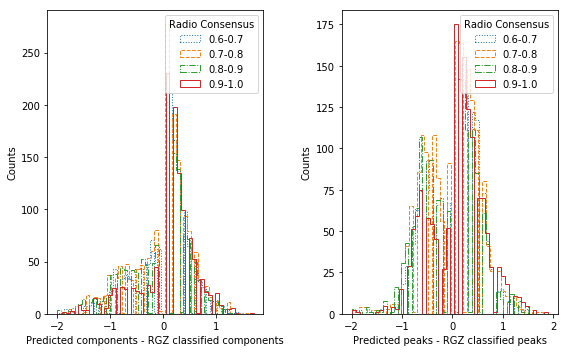

In [31]:
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

for c, b in enumerate(np.sort(bin_df.unique())):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()



0.6-0.7
0.7-0.8
0.8-0.9
0.9-1.0


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


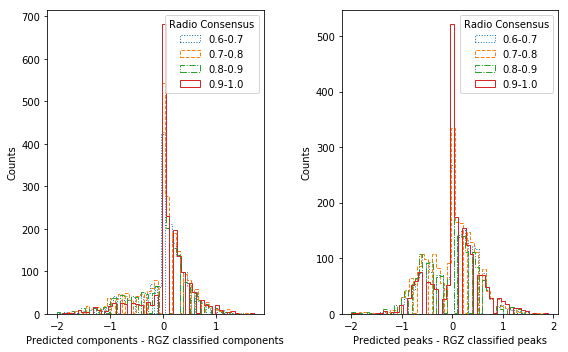

In [32]:
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

for c, b in enumerate(np.sort(bin_df.unique())):
    print(b)
    mask = b == bin_df
    
    val = comp_res - num_comp
    ax1.hist( val[mask], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
    
    val = peaks_res - num_peaks
    ax2.hist(val[mask], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='Radio Consensus')
fig.tight_layout()
fig.show()


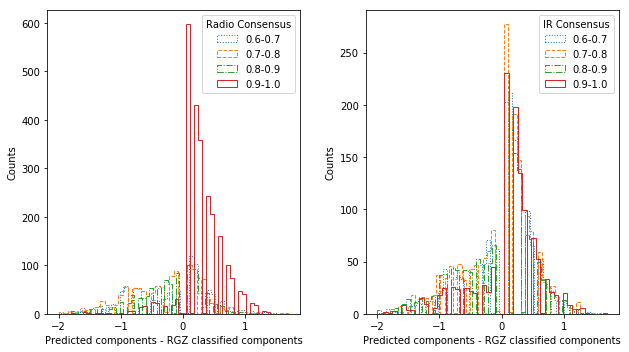

In [33]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,5))
linestyles = [':','--','-.','-']

val = comp_res - num_comp

bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

    
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax2.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted components - RGZ classified components',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='IR Consensus')
fig.tight_layout()
# fig.show()
fig.savefig('Images/Components_Histogram_Consensus.pdf')


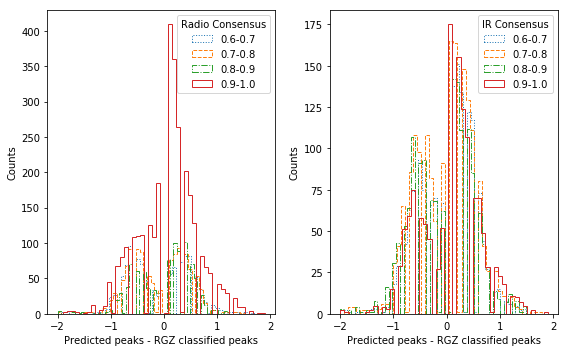

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-']

val = peaks_res - num_peaks

bin_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax1.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

    
bin_df = pd.cut(suf_df['consensus.ir_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
for c, b in enumerate(np.sort(bin_df.unique())):
    mask = b == bin_df    
    ax2.hist( val[(mask)&(val!=0)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted peaks - RGZ classified peaks',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='Radio Consensus')
ax2.legend(title='IR Consensus')
fig.tight_layout()
# fig.show()
fig.savefig('Images/Peaks_Histogram_Consensus.pdf')

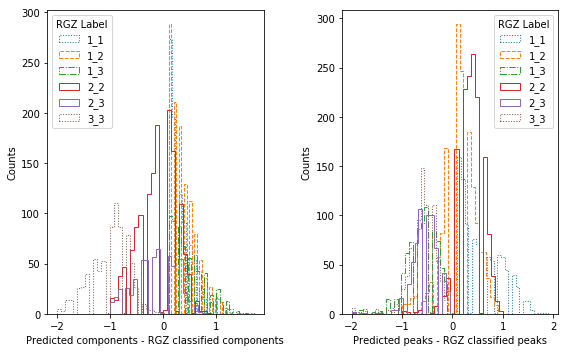

In [35]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,5))
linestyles = [':','--','-.','-', '-',':']

val = comp_res - num_comp

bin_df = np.unique(suf_df['label'])
for c, b in enumerate(np.sort(bin_df)):
    mask = b ==  suf_df['label']   
    ax1.hist( val[(mask)&(val!=0)], bins=25, label=f'{b}', histtype='step', linestyle=linestyles[c])


val = peaks_res - num_peaks


bin_df = np.unique(suf_df['label'])
for c, b in enumerate(np.sort(bin_df)):
    mask = b == suf_df['label']    
    ax2.hist( val[(mask)&(val!=0)], bins=25, label=f'{b}', histtype='step', linestyle=linestyles[c])

ax1.set(xlabel='Predicted components - RGZ classified components',
            ylabel='Counts')
ax2.set(xlabel='Predicted peaks - RGZ classified peaks',
        ylabel='Counts')

ax1.legend(title='RGZ Label')
ax2.legend(title='RGZ Label')
fig.tight_layout()
# fig.show()
fig.savefig('Images/RGZ_Label_Predicted_Features.pdf')

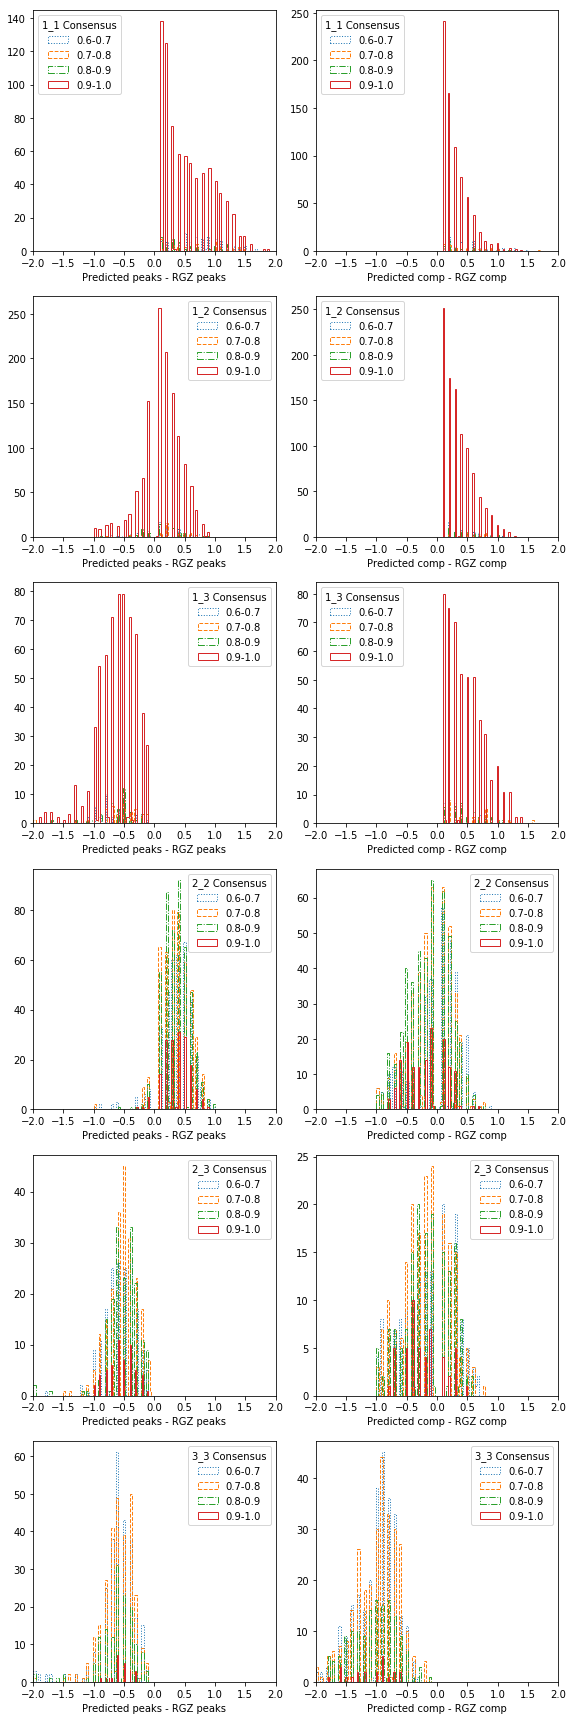

In [36]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(val_peak!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(val_comp!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_Label_Consensus_Histogram.pdf')

In [37]:
bin_df

array(['1_1', '1_2', '1_3', '2_2', '2_3', '3_3'], dtype=object)

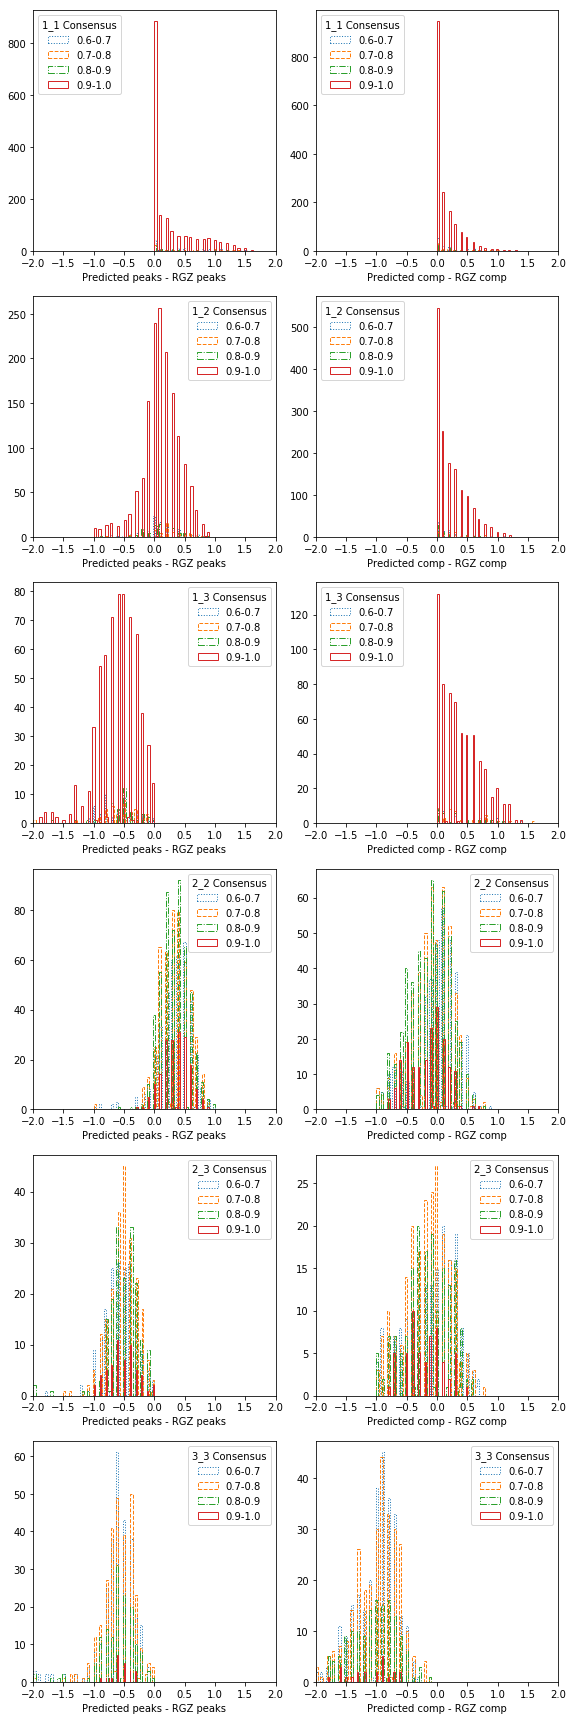

In [38]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
# fig.show()
fig.savefig('Images/Figure_Label_Consensus_Histogram_With_Zero.pdf')

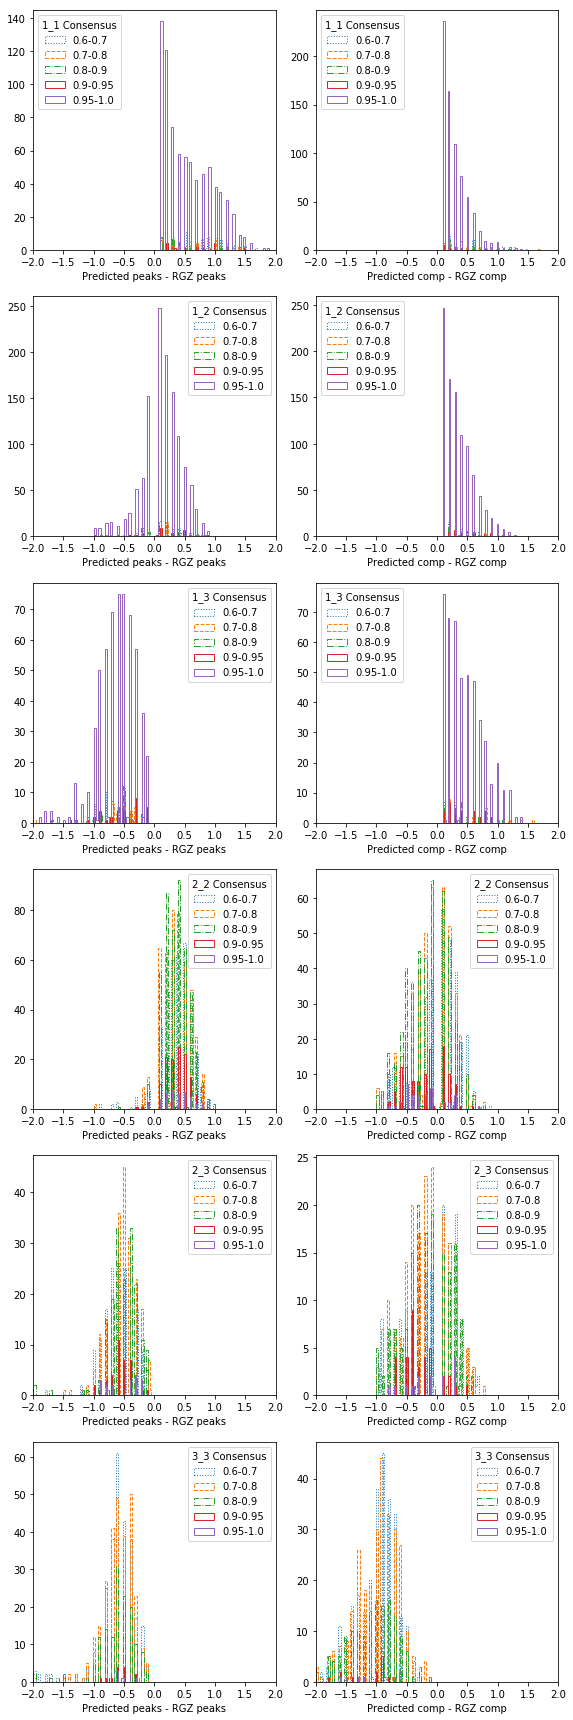

In [39]:
bin_df = np.unique(suf_df['label'])
linestyles = [':','--','-.','-', '-',':', '--']

fig, axes = plt.subplots(len(bin_df), 2, figsize=(8, len(bin_df)*4))

for count, l in enumerate(np.sort(bin_df)):
    ax1, ax2 = axes[count]
    
    l_mask = l == suf_df['label']
    val_peak = peaks_res - num_peaks
    val_comp = comp_res - num_comp 
    
    cen_df = pd.cut(suf_df['consensus.radio_level'] , [0.6, 0.7, 0.8, 0.9, 0.95, 1.0], labels=['0.6-0.7','0.7-0.8','0.8-0.9','0.9-0.95', '0.95-1.0',])
    for c, b in enumerate(np.sort(cen_df.unique())):
        mask = b == cen_df    
        ax1.hist( val_peak[(mask)&(val_peak!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax1.legend(title=f'{l} Consensus')
        ax1.set(xlim=[-2,2], xlabel='Predicted peaks - RGZ peaks')
        
        ax2.hist( val_comp[(mask)&(val_comp!=0)&(l_mask)], bins=50, label=f'{b}', histtype='step', linestyle=linestyles[c])
        ax2.legend(title=f'{l} Consensus')
        ax2.set(xlim=[-2,2], xlabel='Predicted comp - RGZ comp')

fig.tight_layout()
# fig.show()